# Regularization

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_percentage_error, f1_score, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer,
)
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
data_directory = r"C:\Users\said_\OneDrive\Masaüstü\github\Machine Learning in Finance\Datasets"

## Regularized Linear Regression for Predicting House Price 

- We will implement a regularized linear regression by using sklearn to predict house sale price (last column) by using all remaining attributes over the Real State Price dataset.
- We will implement L1 norm (Lasso) and L2 norm (Ridge) regularized linear regression by using sklearn library.
- To find the optimal regularization hyperparameter lambda, we will apply 5-fold cross-validation and test different lambda values: 0.001, 0.01, 0.1, 0.25, 0.5, 1.0].
- The evaluation metric is Root Mean Squared Error (RMSE).

In [4]:
data = pd.read_csv(os.path.join(data_directory, "kaggle_house.csv"))
print(data.shape)

(1460, 81)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# Remove the columns with too many missing values
columns_removed = ["Alley", "MasVnrType", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]

mydf = data.drop(columns=columns_removed)

# Remove rows with missing values in categorical columns
categorical_columns = mydf.select_dtypes(include=['object']).columns
mydf = mydf.dropna(subset=categorical_columns)

# Apply mean imputation for the missing values in numerical columns
numerical_columns = mydf.select_dtypes(include=['number']).columns
mydf[numerical_columns] = mydf[numerical_columns].fillna(mydf[numerical_columns].mean())

mydf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1346 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1346 non-null   int64  
 1   MSSubClass     1346 non-null   int64  
 2   MSZoning       1346 non-null   object 
 3   LotFrontage    1346 non-null   float64
 4   LotArea        1346 non-null   int64  
 5   Street         1346 non-null   object 
 6   LotShape       1346 non-null   object 
 7   LandContour    1346 non-null   object 
 8   Utilities      1346 non-null   object 
 9   LotConfig      1346 non-null   object 
 10  LandSlope      1346 non-null   object 
 11  Neighborhood   1346 non-null   object 
 12  Condition1     1346 non-null   object 
 13  Condition2     1346 non-null   object 
 14  BldgType       1346 non-null   object 
 15  HouseStyle     1346 non-null   object 
 16  OverallQual    1346 non-null   int64  
 17  OverallCond    1346 non-null   int64  
 18  YearBuilt    

In [7]:
# Define features and target
X = mydf.drop(columns="SalePrice")
y = mydf["SalePrice"].values

# Aplly one-hot-encoding to the categorical columns
X = pd.get_dummies(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train shape: {X_train_scaled.shape}")
print(f"Test shape: {X_test_scaled.shape}")

Train shape: (1076, 262)
Test shape: (270, 262)


### Lasso Regression (L1 Regularization)

The objective of Lasso regression is to minimize the following loss function:

$$
\text{Lasso Loss} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{p} | \beta_j |
$$

The L1 regularization term $\sum_{j=1}^{p} | \beta_j | $ encourages sparsity, causing some coefficients to be exactly zero.

---

### Ridge Regression (L2 Regularization)

The objective of Ridge regression is to minimize the following loss function:

$$
\text{Ridge Loss} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{p} \beta_j^2
$$

The L2 regularization term $\sum_{j=1}^{p} \beta_j^2$ penalizes the squared magnitude of the coefficients but does not drive them to zero. Ridge regression shrinks the coefficients but typically does not eliminate them completely.

> Notation:
>- $y_i$ is the true value for the \(i\)-th observation.
>- $\hat{y}_i$ is the predicted value for the \(i\)-th observation.
>- $n$ is the number of observations.
>- $\lambda$ is the regularization parameter.
>- $\beta_j$ are the coefficients of the features.
>- $p$ is the number of features.

### Hyperparameter Tuning

In [8]:
# Use RMSE for the reference metric in hyperparameter tuning
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Hyperparameter tuning using GridSearchCV
lambda_list = [0.001, 0.01, 0.1, 0.25, 0.5, 1.0]

n_iter = 1000

# Lasso Regression (L1 Regularization)
lasso_model = Lasso(max_iter=n_iter)
lasso_grid = GridSearchCV(
    estimator=lasso_model,
    param_grid={'alpha': lambda_list},
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1
)
lasso_grid.fit(X_train_scaled, y_train)
best_lambda_l1 = lasso_grid.best_params_["alpha"]
best_rmse_l1 = lasso_grid.best_score_

# Ridge Regression (L2 Regularization)
ridge_model = Ridge(max_iter=n_iter)
ridge_grid = GridSearchCV(
    estimator=ridge_model,
    param_grid={'alpha': lambda_list},
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1
)
ridge_grid.fit(X_train_scaled, y_train)
best_lambda_l2 = ridge_grid.best_params_["alpha"]
best_rmse_l2 = ridge_grid.best_score_

C:\Users\said_\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.223e+10, tolerance: 7.066e+08
  model = cd_fast.enet_coordinate_descent(


In [9]:
# Re-train models with the best Lambda values and make predictions
lasso_best_model = lasso_grid.best_estimator_
ridge_best_model = ridge_grid.best_estimator_

In [10]:
# Make predictions and evaluate test scores
y_pred_lasso = lasso_best_model.predict(X_test_scaled)
y_pred_ridge = ridge_best_model.predict(X_test_scaled)

lasso_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_r2_test = r2_score(y_test, y_pred_lasso)

ridge_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_r2_test = r2_score(y_test, y_pred_ridge)

# Define a results df
results = {
    "Model": ["Lasso (L1)", "Ridge (L2)"],
    "Best Lambda": [best_lambda_l1, best_lambda_l2],
    "Validation RMSE": [best_rmse_l1, best_rmse_l2],
    "Test RMSE": [lasso_rmse_test, ridge_rmse_test],
    "Test R2-Score": [lasso_r2_test, ridge_r2_test]
}

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)
results_df.round(3)

,Model,Best Lambda,Validation RMSE,Test RMSE,Test R2-Score
0,Lasso (L1),0.001,35543.553,35751.670,0.741
1,Ridge (L2),0.001,35427.553,36039.697,0.737


**Discussion:** The Lasso and Ridge regression models have the same best lambda value (0.001), suggesting that both models benefit similarly from a small regularization strength. Each model performs similarly on the validation set, with Ridge having a slightly better validation RMSE. However, Lasso performed somewhat better on the unseen test data than Ridge, with a slightly lower test RMSE and a higher R2 score. Thus, it might be better to choose L1 regularization (Lasso) to predict house prices in this case.

## Logistic Regression for Determining Home Ownership Type on Lending Data

- We will now focus on determining the home ownership type (e.g., mortgage or rent) in the "lending_data.xlsx" by using L1 regularized logistic regression
- To find the optimal regularization hyperparameter lambda, we will apply 5-fold cross-validation where lambda can be: 0.001, 0.01, 0.1, 0.25, 0.5, 1.0.
- The evaluation metric is F1 score.

In [11]:
lending_data = pd.read_excel(os.path.join(data_directory, "lending_data.xlsx"))
print(lending_data.shape)

(396030, 26)


In [12]:
lending_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [13]:
mydf = lending_data.copy()

# Remove rows with missing values in categorical columns
categorical_columns = mydf.select_dtypes(include=['object']).columns
mydf = mydf.dropna(subset=categorical_columns)

# Apply mean imputation for the missing values in numerical columns
numerical_columns = mydf.select_dtypes(include=['number']).columns
mydf[numerical_columns] = mydf[numerical_columns].fillna(mydf[numerical_columns].mean())

mydf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 371384 entries, 0 to 396029
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             371384 non-null  float64
 1   term                  371384 non-null  object 
 2   int_rate              371384 non-null  float64
 3   installment           371384 non-null  float64
 4   grade                 371384 non-null  object 
 5   sub_grade             371384 non-null  object 
 6   emp_title             371384 non-null  object 
 7   emp_length            371384 non-null  object 
 8   home_ownership        371384 non-null  object 
 9   annual_inc            371384 non-null  float64
 10  verification_status   371384 non-null  object 
 11  issue_d               371384 non-null  object 
 12  loan_status           371384 non-null  object 
 13  purpose               371384 non-null  object 
 14  title                 371384 non-null  object 
 15  dti  

**Note:** Some categorical columns have too many classes. This makes the data extremely huge when one-hot-encoding is applied. Therefore, the categorical columns with many classes are removed for simplicity.

In [14]:
for i in categorical_columns:
    print(i, mydf[i].value_counts().shape[0])

term 2
grade 7
sub_grade 35
emp_title 172572
emp_length 11
home_ownership 6
verification_status 3
issue_d 115
loan_status 2
purpose 14
title 45763
earliest_cr_line 664
initial_list_status 2
application_type 3


In [15]:
extreme_columns = ["sub_grade", "emp_title", "issue_d", "title", "earliest_cr_line"]
mydf = mydf.drop(columns=extreme_columns)
print(mydf.shape)

(371384, 21)


In [16]:
# Check the class distribution in the target column
mydf['home_ownership'].value_counts()

home_ownership
MORTGAGE    186520
RENT        151092
OWN          33635
OTHER          107
NONE            29
ANY              1
Name: count, dtype: int64

In [17]:
# Remove rows where 'home_ownership' is "OTHER", "NONE", or "ANY" for simplicity
mydf = mydf[~mydf['home_ownership'].isin(['OTHER', 'NONE', 'ANY'])]
# Check the class distribution in the target column after cleansing
mydf['home_ownership'].value_counts()

home_ownership
MORTGAGE    186520
RENT        151092
OWN          33635
Name: count, dtype: int64

In [18]:
# Define features and target
X = mydf.drop(columns="home_ownership")
y = mydf["home_ownership"].values

# Aplly one-hot-encoding to the categorical columns
X = pd.get_dummies(X)
print(f"Data shape after one-hot-encoding: {X.shape}")

# Split data into train and test sets with an equal class distribution in the targets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Normalize data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train shape: {X_train_scaled.shape}")
print(f"Test shape: {X_test.shape}")

Data shape after one-hot-encoding: (371247, 56)
Train shape: (296997, 56)
Test shape: (74250, 56)


In [21]:
# Define the hyperparameter search space
param_grid = {"C": [1/val for val in [0.001, 0.01, 0.1, 0.25, 0.5, 1.0]]}

# Logistic Regression with L1 penalty (Lasso)
logreg_l1 = LogisticRegression(penalty="l1", solver="saga", max_iter=1000)
grid_search_l1 = GridSearchCV(
    logreg_l1, param_grid, cv=5, 
    scoring="f1_weighted", n_jobs=-1, verbose=1,
)
grid_search_l1.fit(X_train_scaled, y_train)

# Get the best model and lambda value
best_model_l1 = grid_search_l1.best_estimator_
best_lambda_l1 = 1 / grid_search_l1.best_params_["C"]
best_f1_l1 = grid_search_l1.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [25]:
# Create a df to log validation F1-scores for different lambda values
lambda_results = pd.DataFrame({
    "Lambda": [1 / C for C in grid_search_l1.cv_results_["param_C"]],
    "Mean Validation F1": grid_search_l1.cv_results_["mean_test_score"],
    "Std Validation F1": grid_search_l1.cv_results_["std_test_score"]
})

# Sort by the validation F-1 score
lambda_results = lambda_results.sort_values(by="Mean Validation F1", ascending=False)
lambda_results.sort_values(by="Mean Validation F1", ascending=False)

,Lambda,Mean Validation F1,Std Validation F1
5,1.000,0.676151,0.001540
0,0.001,0.676148,0.001548
1,0.010,0.676148,0.001548
4,0.500,0.676148,0.001526
3,0.250,0.676148,0.001543
2,0.100,0.676145,0.001545


Lambda (1.0) performs relatively better with the highest F1 Score than the other lambda values.

In [26]:
# Evaluate the best model on the test set
best_model_l1 = LogisticRegression(C=1.0, penalty="l1", solver="saga", max_iter=1000)
best_model_l1.fit(X_train_scaled, y_train)
y_test_pred_l1 = best_model_l1.predict(X_test_scaled)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_l1))


Classification Report (Test Set):
              precision    recall  f1-score   support

    MORTGAGE       0.75      0.78      0.76     37304
         OWN       0.25      0.00      0.00      6727
        RENT       0.66      0.78      0.72     30219

    accuracy                           0.71     74250
   macro avg       0.55      0.52      0.49     74250
weighted avg       0.67      0.71      0.68     74250



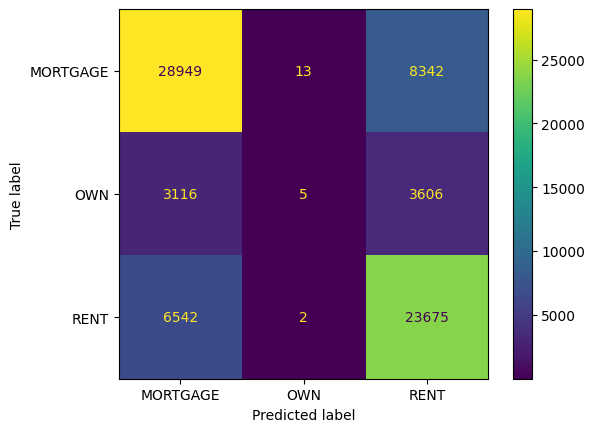

In [31]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_l1)

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_l1.classes_)

# Plot the confusion matrix
cm_display.plot(cmap="viridis")
plt.show()

In [32]:
# Let us recall the class distribution in the target variable
mydf['home_ownership'].value_counts()

home_ownership
MORTGAGE    186520
RENT        151092
OWN          33635
Name: count, dtype: int64

In [34]:
# Now, let us calculate class-specific accuracies
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Display accuracies for each class
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {best_model_l1.classes_[i]} accuracy: {accuracy:.2%}")

Class MORTGAGE accuracy: 77.60%
Class OWN accuracy: 0.07%
Class RENT accuracy: 78.34%


**Discussion:** The low validation F1 score (0.676) is primarily due to the imbalanced distribution of classes, as evidenced by the extreme differences in class-specific accuracies: "MORTGAGE" and "RENT" have high accuracies (77.60% and 78.34%, respectively), while "OWN" has an extremely low accuracy of 0.07%. This likely indicates that "OWN" is significantly underrepresented in the dataset, causing the model to struggle to learn its patterns and favor the majority classes ("MORTGAGE" and "RENT") instead. Such class imbalances spoil the model's performance, as it prioritizes optimizing for the dominant classes. In this sense, resampling techniques or cost-sensitive learning can be possible solutions.

# END